## Clustering SCADA Data analysis

In [1]:
# Import relevant libraries
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from scada_data_analysis.modules.power_curve_preprocessing import PowerCurveFiltering

In [2]:
# Load data
df_scada = pd.read_csv('wtbdata_245days.csv.zip')
df_loc = pd.read_csv('sdwpf_baidukddcup2022_turb_location.csv')

### Data Exploration

##### Explore turbine scada data

In [3]:
df_scada.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [4]:
df_scada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [5]:
df_scada.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,4.727520e+06,4.727520e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06
mean,6.750000e+01,1.230000e+02,5.028376e+00,4.975428e-01,4.110668e+01,2.739717e+01,1.885826e+02,2.685400e+01,2.683916e+01,2.682679e+01,-1.323900e+01,3.504458e+02
std,3.868139e+01,7.072483e+01,3.393703e+00,3.160275e+01,8.529011e+01,1.832832e+01,1.632459e+02,3.883566e+01,3.882940e+01,3.882235e+01,7.044244e+01,4.249932e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,-9.330000e+00
25%,3.400000e+01,6.200000e+01,2.240000e+00,-3.830000e+00,1.405000e+01,2.006000e+01,6.302000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-3.861000e+01,-3.000000e-01
50%,6.750000e+01,1.230000e+02,4.340000e+00,-2.300000e-01,2.573000e+01,3.008000e+01,1.947900e+02,5.400000e-01,5.400000e-01,5.400000e-01,-3.000000e-01,1.790800e+02
75%,1.010000e+02,1.840000e+02,7.010000e+00,3.420000e+00,3.273000e+01,3.682000e+01,3.219600e+02,8.399000e+01,8.398000e+01,8.398000e+01,-3.000000e-02,5.476600e+02
max,1.340000e+02,2.450000e+02,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03


In [6]:
# Identify number of unique turbines in data
df_scada['TurbID'].nunique()

134

##### Explore location data

In [7]:
df_loc.head()

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175


In [8]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TurbID  134 non-null    int64  
 1   x       134 non-null    float64
 2   y       134 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.3 KB


In [9]:
df_scada.shape

(4727520, 13)

### Data Preprocessing

In [10]:
df_scada.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

##### Extract desired features

In [11]:
dff_scada = df_scada[['TurbID',  'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Ndir', 'Patv']]

In [12]:
dff_scada.shape

(4727520, 7)

In [13]:
dff_scada.TurbID.nunique()

134

In [14]:
dff_scada.Day.nunique()

245

##### Data Cleaning

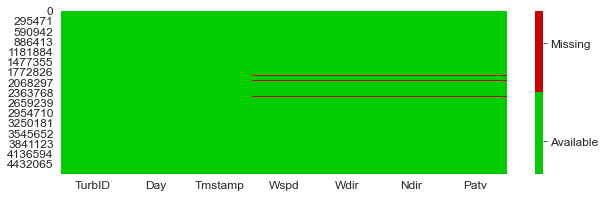

In [15]:
# Investigate missing values
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap

myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# Plot heatmap
plt.figure(figsize=(10, 3))
sns.set_style(style='white')
ax = sns.heatmap(dff_scada.isna().astype(int)+1, cmap=cmap);

# Post-process visualization
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.2, 1.8])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

In [16]:
# Remove rows missing values
original_length = dff_scada.shape[0]
dff_scada = dff_scada.dropna()
dff_scada.reset_index(drop=True)
print(f'{round((original_length-dff_scada.shape[0])/original_length*100, 2)}% of original rows were removed')

1.05% of original rows were removed


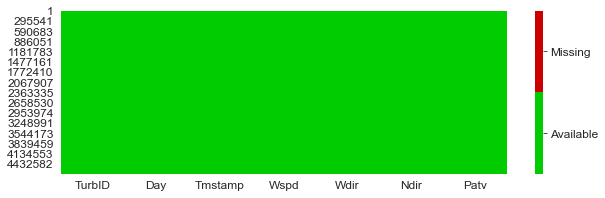

In [17]:
myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

plt.figure(figsize=(10,3))
ax = sns.heatmap(dff_scada.isna().astype(int)+1, cmap=cmap, rasterized=True);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.95, 1.05])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

##### Process time features

In [18]:
%%time
dff_scada['date_time'] = dff_scada[['Day', 'Tmstamp']].apply(lambda x: str(x[0]) + 'T' +str(x[1]), axis=1)

CPU times: total: 43.9 s
Wall time: 44 s


In [19]:
dff_scada['date_time'].nunique()

35016

##### Assign turbines to columns based on x location data

In [20]:
df_loc['x_round'] = df_loc['x'].round(-3)

In [21]:
df_loc['col_num'] = df_loc['x_round'].apply(lambda xx: 'c_0' if xx == 0 else 'c_1' if xx == 1000 else 'c_2' if xx == 2000 else 'c_3' if xx == 3000 else 'c_4' if xx == 4000 else 'c_5')

##### Data Filtering

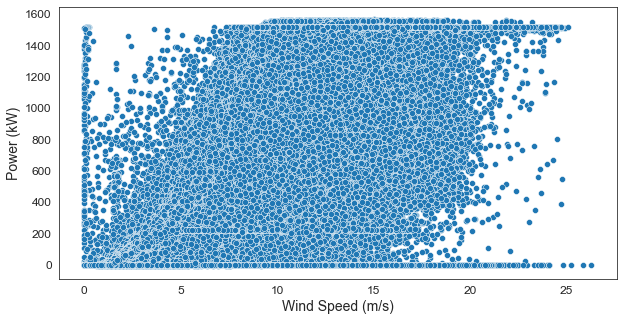

In [22]:
# Visualize raw power curve data
plt.figure(figsize=(10,5))
sns.scatterplot(x='Wspd', y='Patv', data=dff_scada);
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power (kW)', fontsize=14);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [23]:
cut_in_speed = 2.85

In [24]:
%%time
# Remove obvious abnormal points from data
ab_ind = dff_scada[(dff_scada['Wspd'] < cut_in_speed) & (dff_scada['Patv'] > 100)].index

CPU times: total: 203 ms
Wall time: 186 ms


In [25]:
norm_ind = list(set(dff_scada.index).difference(set(ab_ind)))

In [26]:
assert len(dff_scada) == len(norm_ind) + len(ab_ind)

In [27]:
scada_data = dff_scada.loc[norm_ind, :]

In [28]:
scada_data.shape

(4650478, 8)

##### Employ power curve filter to remove non-obvious abnormal points

In [29]:
pc_filter = PowerCurveFiltering(turbine_label='TurbID', windspeed_label='Wspd',
                                power_label='Patv', data=scada_data, cut_in_speed=cut_in_speed, bin_interval=0.5,
                                z_coeff=1.5, filter_cycle=15, return_fig=False)

In [30]:
%%time
cleaned_scada_df, _ = pc_filter.process()

CPU times: total: 3min 1s
Wall time: 3min 2s


In [31]:
cleaned_scada_df.shape

(1899031, 8)

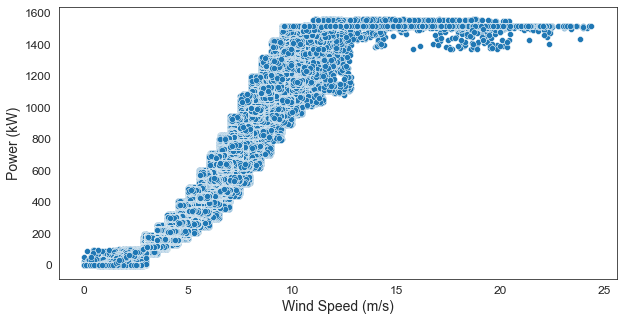

In [32]:
# Visualize cleaned power data

plt.figure(figsize=(10,5))
sns.scatterplot(x='Wspd', y='Patv', data=cleaned_scada_df);
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power (kW)', fontsize=14);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

##### Map turbine column locations to clean scada data

In [33]:
cleaned_scada_df['col_num'] = cleaned_scada_df['TurbID'].replace(df_loc.set_index('TurbID')['col_num']).values

##### Create test data for representativeness evaluation

In [37]:
# Create test data from cleaned SCADA data
df_cleaned_scada_test = cleaned_scada_df.sample(frac=0.0105, random_state=32)
train_ind = list(set(cleaned_scada_df.index).difference(set(df_cleaned_scada_test.index)))
cleaned_scada_data = cleaned_scada_df.loc[train_ind, :]
print('The test data contains', f'{df_cleaned_scada_test.shape[0]} rows',
      'which is', f'{round((df_cleaned_scada_test.shape[0]/cleaned_scada_df.shape[0])*100,2)}% of the cleaned dataset')

The test data contains 19940 rows which is 1.05% of the cleaned dataset


In [38]:
df_cleaned_scada_test = df_cleaned_scada_test.reset_index(drop=True)

### Cluster Modeling

##### Elbow Method for number of cluster selection based on wind speed

In [39]:
%%time
X_ws_df = pd.pivot_table(cleaned_scada_data, values='Wspd', index=['TurbID'], columns=['date_time'], aggfunc=np.mean)

CPU times: total: 1.22 s
Wall time: 1.22 s


In [40]:
X_ws_df.dropna(axis=1, inplace=True)

In [41]:
# Transformed windspeed data
X_ws_df

date_time,100T08:20,100T09:40,100T10:10,100T10:40,103T08:00,103T17:40,103T22:40,103T22:50,104T00:20,104T00:30,...,99T06:00,9T00:20,9T00:30,9T00:50,9T09:40,9T10:00,9T10:20,9T10:50,9T11:00,9T11:10
TurbID,,,,,,,,,,,,,,,,,,,,,
1,1.19,1.24,0.94,1.02,0.83,1.26,1.29,1.30,0.66,0.85,...,1.74,0.81,0.67,0.17,0.98,0.74,1.03,1.17,1.09,1.30
2,1.38,1.32,1.08,0.71,0.61,1.20,1.21,1.24,0.61,0.75,...,1.57,0.97,0.80,0.30,1.24,0.82,1.17,1.35,1.54,1.29
3,1.55,1.15,1.02,0.58,1.82,1.24,1.05,0.90,0.96,0.82,...,1.21,0.89,0.62,0.64,1.01,1.32,1.49,1.43,1.02,1.60
4,1.21,1.18,1.21,0.78,0.53,1.14,1.20,1.15,0.46,1.00,...,1.46,1.22,1.01,0.36,1.15,0.71,1.11,1.39,1.55,1.84
5,1.23,1.25,1.20,0.75,0.38,1.00,1.06,1.00,0.52,0.85,...,1.35,1.14,0.95,0.38,1.11,0.83,1.16,0.98,1.40,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1.47,1.22,1.07,0.56,1.27,0.50,1.01,1.16,1.52,1.60,...,1.45,1.06,0.95,0.91,0.64,0.84,0.77,1.62,1.56,1.81
131,1.62,1.65,0.90,0.97,1.25,0.41,1.11,1.04,1.59,0.99,...,2.20,1.00,0.93,0.90,0.60,0.55,0.63,1.80,1.63,1.89
132,1.31,0.94,1.15,0.51,1.72,0.59,1.29,1.17,1.56,1.42,...,1.11,0.92,1.03,0.87,0.55,0.68,0.86,1.66,1.97,1.53


In [42]:
%%time
inertia_ws =[]
for i in range(1, 67):
    KMS_WS = KMeans(n_clusters = i, random_state=32)
    KMS_WS.fit(X_ws_df)
    # calculates the squared error for clustered points
    inertia_ws.append(KMS_WS.inertia_)

CPU times: total: 12.9 s
Wall time: 12.9 s


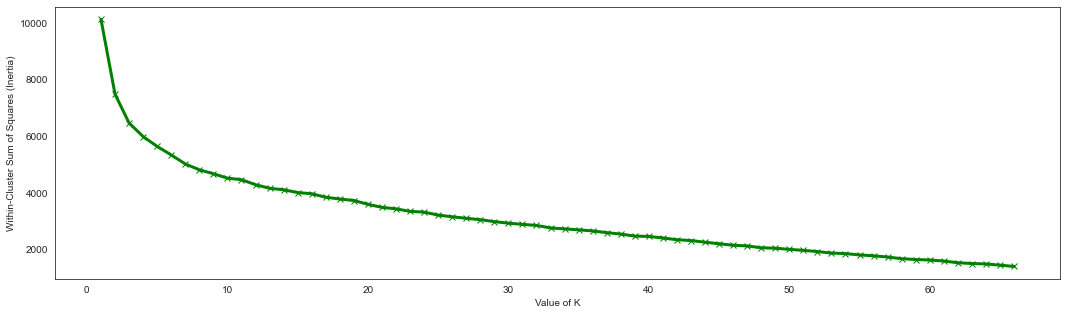

In [43]:
plt.figure(figsize=(18,5))
plt.plot(range(1, 67), inertia_ws, 'gx-', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Within-Cluster Sum of Squares (Inertia)")
plt.show()

##### Turbine clustering based on Wind speed (4 clusters)

In [44]:
KMS_WS = KMeans(n_clusters = 3, random_state=32)

In [45]:
%%time
KMS_WS.fit(X_ws_df)

CPU times: total: 125 ms
Wall time: 137 ms


KMeans(n_clusters=3, random_state=32)

In [46]:
X_ws_dff = X_ws_df.reset_index()

In [47]:
X_ws_dff['cluster_ws'] = KMS_WS.predict(X_ws_df)

In [48]:
%%time
cleaned_scada_data['cluster_ws'] = cleaned_scada_data['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws']).values

CPU times: total: 953 ms
Wall time: 971 ms


#### Elbow Method for number of cluster selection based on wind direction

In [49]:
%%time
X_winddir_df = pd.pivot_table(cleaned_scada_data, values='Wdir', index=['TurbID'], columns=['date_time'], aggfunc=np.mean)

CPU times: total: 1.23 s
Wall time: 1.23 s


In [50]:
X_winddir_df.dropna(axis=1, inplace=True)

In [51]:
%%time
inertia_wd =[]
for i in range(1, 67):
    KMS_WD = KMeans(n_clusters = i, random_state=32)
    KMS_WD.fit(X_winddir_df)
    # calculates the squared error for clustered points
    inertia_wd.append(KMS_WD.inertia_)

CPU times: total: 12.5 s
Wall time: 12.5 s


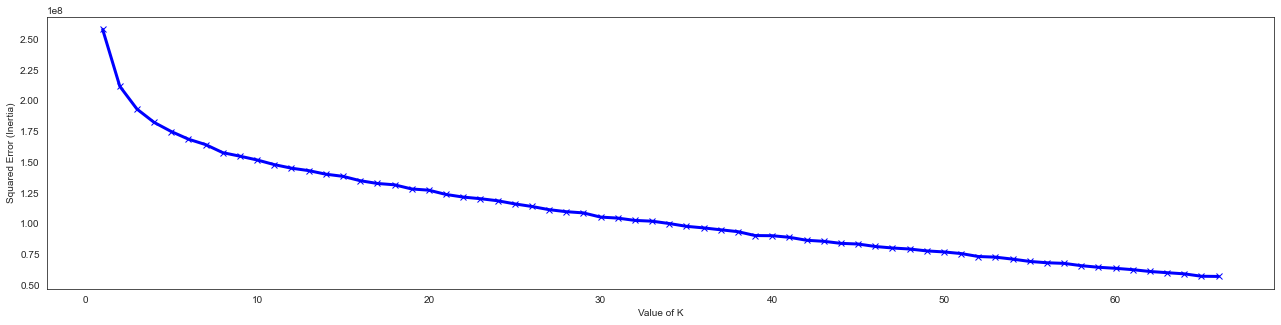

In [52]:
plt.figure(figsize=(22,5))
plt.plot(range(1, 67), inertia_wd, 'bx-', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Inertia)")
plt.show()

##### Turbine clustering based on wind dir

In [53]:
KMS_WD = KMeans(n_clusters = 3, random_state=32)

In [54]:
%%time
KMS_WD.fit(X_winddir_df)

CPU times: total: 125 ms
Wall time: 134 ms


KMeans(n_clusters=3, random_state=32)

In [55]:
X_winddir_dff = X_winddir_df.reset_index()

In [56]:
X_winddir_dff['cluster_wd'] = KMS_WD.predict(X_winddir_df)

In [57]:
%%time
cleaned_scada_data['cluster_wd'] = cleaned_scada_data['TurbID'].replace(X_winddir_dff.set_index('TurbID')['cluster_wd']).values

CPU times: total: 1 s
Wall time: 998 ms


#### Elbow Method for number of cluster selection based on power output

In [58]:
%%time
X_power_df = pd.pivot_table(cleaned_scada_data, values='Patv', index=['TurbID'], columns=['date_time'], aggfunc=np.mean)

CPU times: total: 1.2 s
Wall time: 1.21 s


In [59]:
X_power_df.dropna(axis=1, inplace=True)

In [60]:
%%time
inertia_pow =[]
for i in range(1, 67):
    KMS_P = KMeans(n_clusters = i, random_state=32)
    KMS_P.fit(X_power_df)
    # calculates the squared error for clustered points
    inertia_pow.append(KMS_P.inertia_)

CPU times: total: 13.3 s
Wall time: 13.3 s


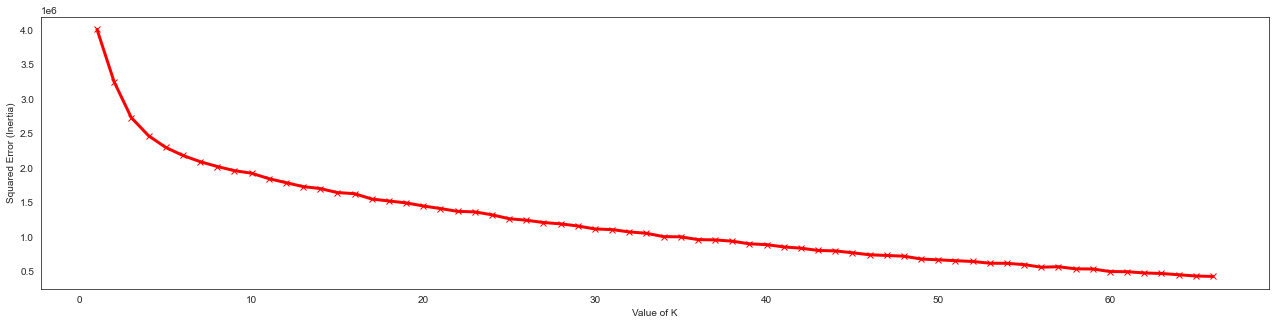

In [61]:
plt.figure(figsize=(22,5))
plt.plot(range(1, 67), inertia_pow, 'rx-', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Inertia)")
plt.show()

##### Elbow Method for number of cluster selection based on power output

In [62]:
KMS_POW = KMeans(n_clusters=3, random_state=32)

In [63]:
%%time
KMS_POW.fit(X_power_df)

CPU times: total: 141 ms
Wall time: 138 ms


KMeans(n_clusters=3, random_state=32)

In [64]:
X_power_dff = X_power_df.reset_index()

In [65]:
X_power_dff['cluster_pow'] = KMS_POW.predict(X_power_df)

In [66]:
%%time
cleaned_scada_data['cluster_pow'] = cleaned_scada_data['TurbID'].replace(X_power_dff.set_index('TurbID')['cluster_pow']).values

CPU times: total: 938 ms
Wall time: 923 ms


##### Elbow method using nacelle direction

In [67]:
%%time
X_nacdir_df = pd.pivot_table(cleaned_scada_data, values='Ndir', index=['TurbID'], columns=['date_time'], aggfunc=np.mean)

CPU times: total: 1.2 s
Wall time: 1.19 s


In [68]:
X_nacdir_df.dropna(axis=1, inplace=True)

In [69]:
%%time
inertia_nd =[]
for i in range(1, 67):
    KMS_ND = KMeans(n_clusters = i, random_state=32)
    KMS_ND.fit(X_nacdir_df)
    # calculates the squared error for clustered points
    inertia_nd.append(KMS_ND.inertia_)

CPU times: total: 12.6 s
Wall time: 12.6 s


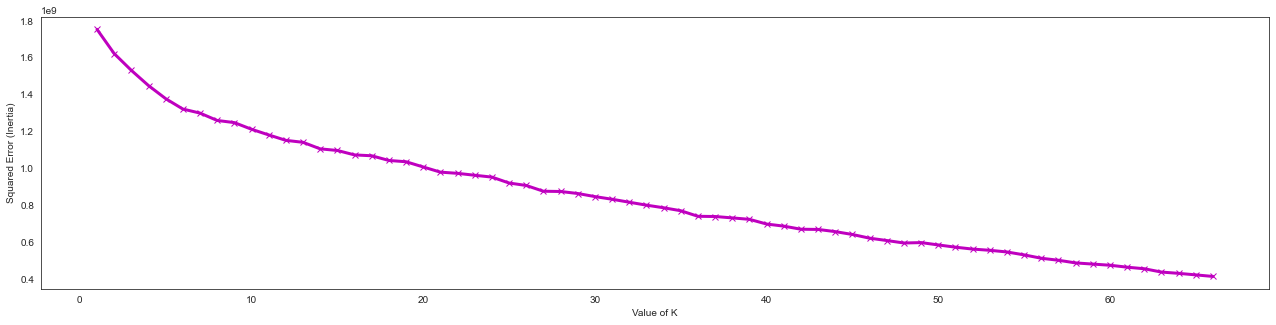

In [70]:
plt.figure(figsize=(22,5))
plt.plot(range(1, 67), inertia_nd, 'mx-', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Inertia)")
plt.show()

##### Turbine clustering based on nacelle dir

In [71]:
KMS_ND = KMeans(n_clusters = 3, random_state=32)

In [72]:
%%time
KMS_ND.fit(X_nacdir_df)

CPU times: total: 141 ms
Wall time: 124 ms


KMeans(n_clusters=3, random_state=32)

In [73]:
X_nacdir_dff = X_nacdir_df.reset_index()

In [74]:
X_nacdir_dff['cluster_nd'] = KMS_ND.predict(X_nacdir_df)

In [75]:
%%time
cleaned_scada_data['cluster_nd'] = cleaned_scada_data['TurbID'].replace(X_nacdir_dff.set_index('TurbID')['cluster_nd']).values

CPU times: total: 938 ms
Wall time: 911 ms


##### Elbow method using all features (wind speed, wind direction, nacelle direction and power)

In [76]:
X_ws_wd_pow_nd_df = pd.concat([X_ws_df, X_winddir_df, X_nacdir_df, X_power_df], axis=1)

In [77]:
X_ws_wd_pow_nd_df.dropna(axis=1, inplace=True)

##### We need to scale this data since we have different range of values and units

In [78]:
scale = StandardScaler()
X_ws_wd_pow_nd_sc = scale.fit_transform(X_ws_wd_pow_nd_df)

In [79]:
%%time
inertia_all =[]
for i in range(1, 67):
    KMS_ALL = KMeans(n_clusters = i, random_state=32)
    KMS_ALL.fit(X_ws_wd_pow_nd_sc)
    # calculates the squared error for clustered points
    inertia_all.append(KMS_ALL.inertia_)

CPU times: total: 20.9 s
Wall time: 20.9 s


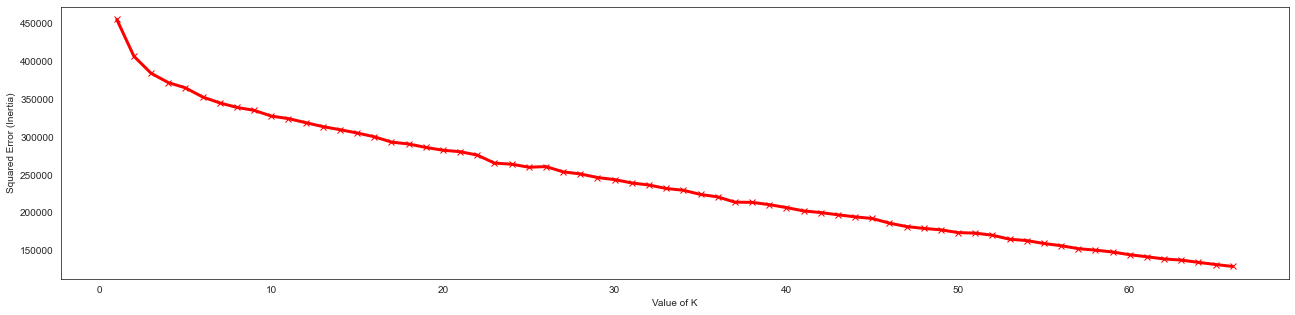

In [80]:
plt.figure(figsize=(22,5))
plt.plot(range(1, 67), inertia_all, 'rx-', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Inertia)")
plt.show()

##### Elbow Method for number of cluster selection based on ws, wdir, ndir and power

In [81]:
KMS_ALL = KMeans(n_clusters = 3, random_state=32)

In [82]:
%%time
KMS_ALL.fit(X_ws_wd_pow_nd_sc)

CPU times: total: 172 ms
Wall time: 160 ms


KMeans(n_clusters=3, random_state=32)

In [83]:
X_ws_wd_pow_nd_dff = X_ws_wd_pow_nd_df.reset_index()

In [84]:
X_ws_wd_pow_nd_dff['cluster_all'] = KMS_ALL.predict(X_ws_wd_pow_nd_sc)

In [85]:
%%time
cleaned_scada_data['cluster_all'] = cleaned_scada_data['TurbID'].replace(X_ws_wd_pow_nd_dff.set_index('TurbID')['cluster_all']).values

CPU times: total: 906 ms
Wall time: 912 ms


##### Elbow plot for individual and all variables

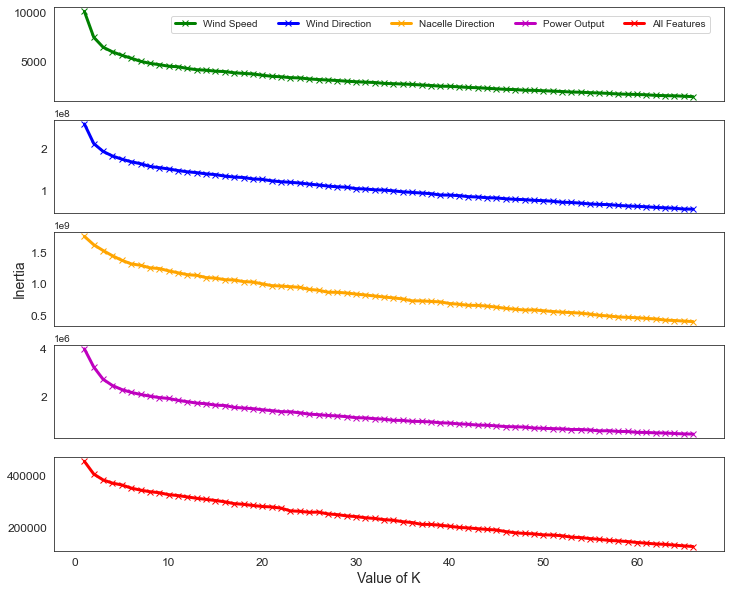

In [86]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex=True, figsize=(12,10))
# wind speed
ax0.plot(range(1, 67), inertia_ws, 'gx-', linewidth ='3')
ax0.tick_params(axis='both', which='both', labelsize=12)
# wind direction
ax1.plot(range(1, 67), inertia_wd, 'bx-', linewidth ='3')
ax1.tick_params(axis='both', which='both', labelsize=12)
# nacelle direction
ax2.plot(range(1, 67), inertia_nd, 'x-', color='orange', linewidth ='3')
ax2.set_ylabel("Inertia", fontsize=14);
ax2.tick_params(axis='both', which='both', labelsize=12)
# power
ax3.plot(range(1, 67), inertia_pow, 'mx-', linewidth ='3')
ax3.tick_params(axis='both', which='both', labelsize=12)
# all features
ax4.plot(range(1, 67), inertia_all, 'rx-', linewidth ='3')
ax4.set_xlabel("Value of K", fontsize=14);
ax4.tick_params(axis='both', which='both', labelsize=12);
labels = ['Wind Speed', 'Wind Direction', 'Nacelle Direction', 'Power Output', 'All Features']
fig.legend(labels=labels, bbox_to_anchor=(0.89,0.875), ncol=len(labels), fontsize=10);

### Results

CPU times: total: 1.91 s
Wall time: 1.92 s


<AxesSubplot:xlabel='Wspd', ylabel='Patv'>

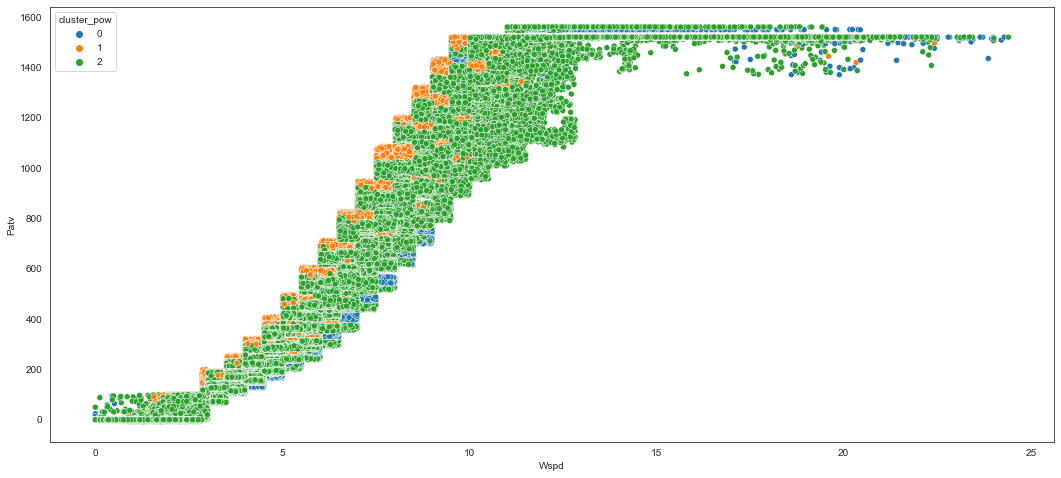

In [87]:
%%time
plt.figure(figsize=(18,8))
sns.scatterplot(x='Wspd', y='Patv', hue='cluster_pow', data=cleaned_scada_data, palette=sns.color_palette()[:3]);

##### Add cluster results to location data

In [88]:
df_loc_clusters = df_loc.copy()

In [89]:
df_loc_clusters['cluster_ws'] = X_ws_dff['cluster_ws']
df_loc_clusters['cluster_wd'] = X_winddir_dff['cluster_wd']
df_loc_clusters['cluster_pow'] = X_power_dff['cluster_pow']
df_loc_clusters['cluster_nd'] = X_nacdir_dff['cluster_nd']
df_loc_clusters['cluster_all'] = X_ws_wd_pow_nd_dff['cluster_all']

##### Visualize clusters with location

CPU times: total: 46.9 ms
Wall time: 39 ms


<AxesSubplot:xlabel='x', ylabel='y'>

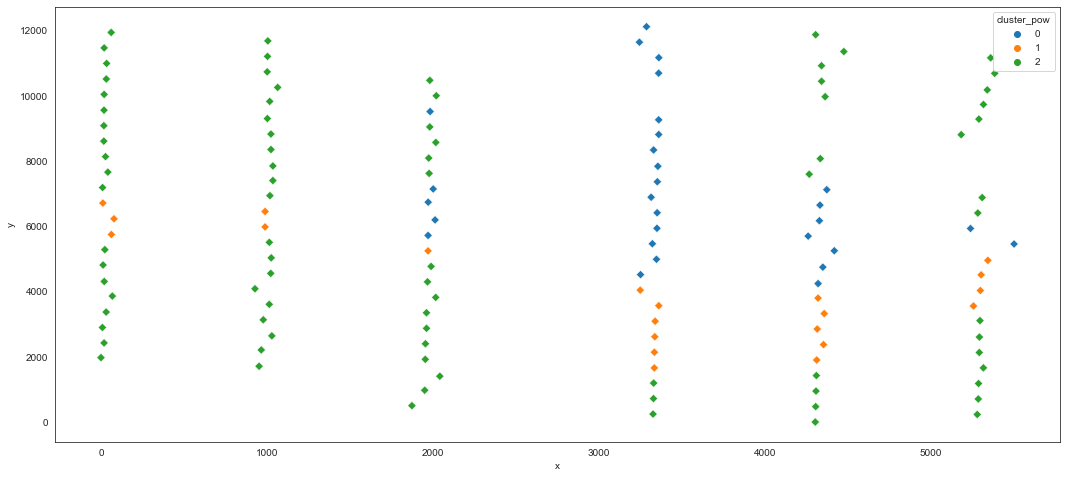

In [90]:
%%time
plt.figure(figsize=(18,8))
sns.scatterplot(x='x', y='y', hue='cluster_pow', data=df_loc_clusters, palette=sns.color_palette()[:3], marker="D");

### Test representativeness of clusters

In [91]:
%%time
# find cluster which test turbine belongs to
df_cleaned_scada_test.loc[:, 'cluster_ws'] = df_cleaned_scada_test['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws']).values
df_cleaned_scada_test.loc[:, 'cluster_wd'] = df_cleaned_scada_test['TurbID'].replace(X_winddir_dff.set_index('TurbID')['cluster_wd']).values
df_cleaned_scada_test.loc[:, 'cluster_nd'] = df_cleaned_scada_test['TurbID'].replace(X_nacdir_dff.set_index('TurbID')['cluster_nd']).values
df_cleaned_scada_test.loc[:, 'cluster_pow'] = df_cleaned_scada_test['TurbID'].replace(X_power_dff.set_index('TurbID')['cluster_pow']).values

CPU times: total: 62.5 ms
Wall time: 53 ms


##### Estimation by naive clustering approach

In [92]:
%%time
scada_merged_ws_naive = cleaned_scada_data.groupby(['cluster_ws', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_naive.columns = ['cluster_ws', 'date_time', 'Wspd_naive_avg']

CPU times: total: 562 ms
Wall time: 579 ms


In [93]:
%%time
df_cleaned_scada_test['ws_naive_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_naive, how='left', on=['cluster_ws', 'date_time'])['Wspd_naive_avg']

CPU times: total: 46.9 ms
Wall time: 52 ms


In [94]:
%%time
scada_merged_wd_naive = cleaned_scada_data.groupby(['cluster_wd', 'date_time'], as_index=False)['Wdir'].mean()
scada_merged_wd_naive.columns = ['cluster_wd', 'date_time',  'Wdir_naive_avg']

CPU times: total: 750 ms
Wall time: 803 ms


In [95]:
df_cleaned_scada_test['wd_naive_pred'] = df_cleaned_scada_test.merge(scada_merged_wd_naive, how='left', on=['cluster_wd', 'date_time'])['Wdir_naive_avg']

In [96]:
%%time
scada_merged_nd_naive = cleaned_scada_data.groupby(['cluster_nd', 'date_time'], as_index=False)['Ndir'].mean()
scada_merged_nd_naive.columns = ['cluster_nd', 'date_time',  'Ndir_naive_avg']

CPU times: total: 547 ms
Wall time: 535 ms


In [97]:
df_cleaned_scada_test['nd_naive_pred'] = df_cleaned_scada_test.merge(scada_merged_nd_naive, how='left', on=['cluster_nd', 'date_time'])['Ndir_naive_avg']

In [98]:
%%time
scada_merged_pow_naive = cleaned_scada_data.groupby(['cluster_pow', 'date_time'], as_index=False)['Patv'].mean()
scada_merged_pow_naive.columns = ['cluster_pow', 'date_time',  'Patv_naive_avg']

CPU times: total: 469 ms
Wall time: 451 ms


In [99]:
df_cleaned_scada_test['pow_naive_pred'] = df_cleaned_scada_test.merge(scada_merged_pow_naive, how='left', on=['cluster_pow', 'date_time'])['Patv_naive_avg']

##### Estimation by column-wise clustering approach

In [100]:
%%time
scada_merged_ws_col = cleaned_scada_data.groupby(['col_num', 'cluster_ws', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_col.columns = ['col_num', 'cluster_ws', 'date_time', 'Wspd_col_avg']

CPU times: total: 719 ms
Wall time: 714 ms


In [101]:
%%time
df_cleaned_scada_test['ws_col_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_col, how='left', on=['col_num', 'cluster_ws', 'date_time'])['Wspd_col_avg']

CPU times: total: 234 ms
Wall time: 244 ms


In [102]:
%%time
scada_merged_wd_col = cleaned_scada_data.groupby(['col_num', 'cluster_wd', 'date_time'], as_index=False)['Wdir'].mean()
scada_merged_wd_col.columns = ['col_num', 'cluster_wd', 'date_time',  'Wdir_col_avg']

CPU times: total: 750 ms
Wall time: 746 ms


In [103]:
df_cleaned_scada_test['wd_col_pred'] = df_cleaned_scada_test.merge(scada_merged_wd_col, how='left', on=['col_num', 'cluster_wd', 'date_time'])['Wdir_col_avg']

In [104]:
%%time
scada_merged_nd_col = cleaned_scada_data.groupby(['col_num', 'cluster_nd', 'date_time'], as_index=False)['Ndir'].mean()
scada_merged_nd_col.columns = ['col_num', 'cluster_nd', 'date_time',  'Ndir_col_avg']

CPU times: total: 703 ms
Wall time: 699 ms


In [105]:
df_cleaned_scada_test['nd_col_pred'] = df_cleaned_scada_test.merge(scada_merged_nd_col, how='left', on=['col_num', 'cluster_nd', 'date_time'])['Ndir_col_avg']

In [106]:
%%time
scada_merged_pow_col = cleaned_scada_data.groupby(['col_num', 'cluster_pow', 'date_time'], as_index=False)['Patv'].mean()
scada_merged_pow_col.columns = ['col_num', 'cluster_pow', 'date_time',  'Patv_col_avg']

CPU times: total: 688 ms
Wall time: 679 ms


In [107]:
df_cleaned_scada_test['pow_col_pred'] = df_cleaned_scada_test.merge(scada_merged_pow_col, how='left', on=['col_num', 'cluster_pow', 'date_time'])['Patv_col_avg']

In [108]:
df_cleaned_scada_test.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Ndir', 'Patv', 'date_time',
       'col_num', 'cluster_ws', 'cluster_wd', 'cluster_nd', 'cluster_pow',
       'ws_naive_pred', 'wd_naive_pred', 'nd_naive_pred', 'pow_naive_pred',
       'ws_col_pred', 'wd_col_pred', 'nd_col_pred', 'pow_col_pred'],
      dtype='object')

##### Extract only rows with prediction of wind speed for evaluation (non-NA rows)

In [109]:
df_cleaned_scada_test_ws =  df_cleaned_scada_test.dropna(subset=['ws_naive_pred', 'ws_col_pred'])[['TurbID', 'Day', 'Tmstamp', 'Wspd',
                                                                                                   'col_num', 'cluster_ws', 'ws_naive_pred',
                                                                                                   'ws_col_pred']]

In [110]:
print('The naive clustering method fills',round(len(df_cleaned_scada_test['ws_naive_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The naive clustering method fills 99.7 % of original missing data


In [111]:
print('The column-based clustering method fills',round(len(df_cleaned_scada_test['ws_col_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The column-based clustering method fills 93.7 % of original missing data


##### Evaluate cluster approaches

In [113]:
mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_naive_pred.values)

0.3321457627912348

In [114]:
mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_col_pred.values)

0.3246627949808942

In [115]:
df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0].shape

(18595, 8)

##### Compute MAPE metric for non-zero missing values

In [116]:
mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values, df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_naive_pred.values)

0.1709727638502125

In [117]:
mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values, df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_col_pred.values)

0.1576929061020317

##### Visualize prediction results

In [118]:
df_cleaned_scada_test_ws['ws_naive_error'] = df_cleaned_scada_test_ws.Wspd - df_cleaned_scada_test_ws.ws_naive_pred
df_cleaned_scada_test_ws['ws_col_error'] =  df_cleaned_scada_test_ws.Wspd - df_cleaned_scada_test_ws.ws_col_pred

In [119]:
ws_box_data_n = df_cleaned_scada_test_ws[['ws_naive_error']].reset_index(drop=True)
ws_box_data_c = df_cleaned_scada_test_ws[['ws_col_error']].reset_index(drop=True)

In [120]:
ws_box_data_n['Approach'] = 'NC'
ws_box_data_c['Approach'] = 'SCS'

In [121]:
ws_box_data_n.columns = ['Imputation Error', 'Approach']
ws_box_data_c.columns = ['Imputation Error', 'Approach']

In [122]:
ws_box_data = pd.concat([ws_box_data_n, ws_box_data_c])

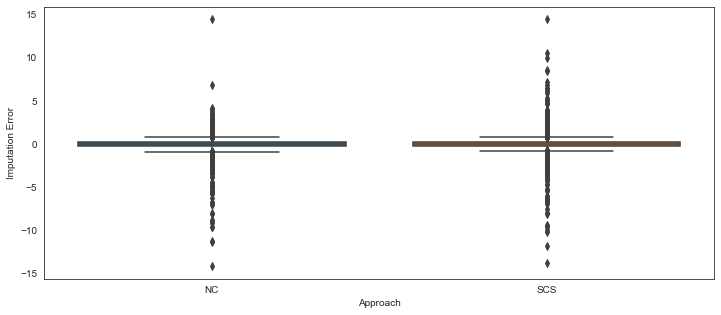

In [123]:
plt.figure(figsize=(12,5))
ax = sns.boxplot(x='Approach', y='Imputation Error', data=ws_box_data)

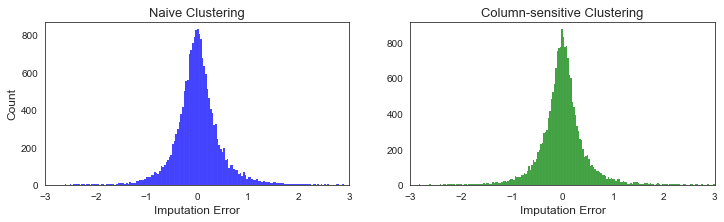

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
#NC Approach
l = sns.histplot(df_cleaned_scada_test_ws['ws_naive_error'], color='blue', ax=axes[0])
l.set_xlim([-3,3])
l.set_xlabel('Imputation Error', fontsize=12);
l.set_title('Naive Clustering', fontsize=13)
l.set_ylabel('Count', fontsize=12);

#SCS Approach
m = sns.histplot(df_cleaned_scada_test_ws['ws_col_error'], color='green', ax=axes[1])
m.set_xlim([-3, 3]);
m.set_xlabel('Imputation Error', fontsize=12);
m.set_ylabel(' ', fontsize=12);
m.set_title('Column-sensitive Clustering', fontsize=13);

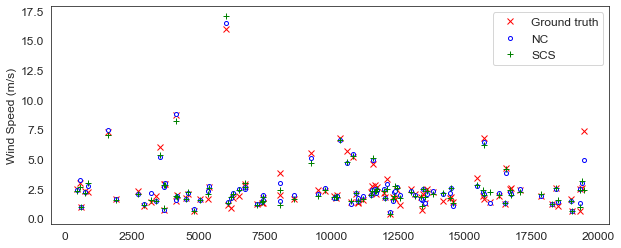

In [125]:
plt.figure(figsize=(10,4))
plt.plot(df_cleaned_scada_test_ws['Wspd'].sample(n=100, random_state=20), 'xr')
plt.plot(df_cleaned_scada_test_ws['ws_naive_pred'].sample(n=100, random_state=20), 'ob', markersize=4, mfc='white')
plt.plot(df_cleaned_scada_test_ws['ws_col_pred'].sample(n=100, random_state=20), '+g')
plt.legend(labels=['Ground truth', 'NC', 'SCS'], fontsize=12);
plt.ylabel('Wind Speed (m/s)', fontsize=12);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

### Save processed data

In [ ]:
# cleaned_scada_data.to_csv('cleaned_scada_data.csv', index=False)

In [ ]:
# df_loc_clusters.to_csv('turbine_loc_cluster_data.csv', index=False)

In [ ]:
# df_cleaned_scada_test.to_csv('missing_values_test_data.csv', index=False)

In [274]:
# df_cleaned_scada_test_ws.to_csv('ws_missing_values_results.csv')